In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import StrMethodFormatter
from datetime import datetime, timezone

In [35]:
# save data in a DataFrame
data = pd.read_csv('/content/clean_secular_talk_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   videoId           19999 non-null  object 
 1   title             19999 non-null  object 
 2   description       19622 non-null  object 
 3   tags              19570 non-null  object 
 4   publishedAt       19999 non-null  object 
 5   duration          19999 non-null  object 
 6   category          19999 non-null  object 
 7   viewCount         19999 non-null  int64  
 8   likeCount         19999 non-null  int64  
 9   commentCount      19998 non-null  float64
 10  duration_seconds  19999 non-null  int64  
 11  duration_minutes  19999 non-null  float64
 12  duration_hours    19999 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 2.0+ MB


In [36]:
# filter videos that last more than 3 hours
data = data.loc[data["duration_seconds"] < 3 * 3600].copy()

# delete videos with more like than views
data = data[~(data["likeCount"] > data["viewCount"])]

# clean date column
data['publishedAt'] = pd.to_datetime(data['publishedAt'])

# filter counts
attributes = [
    "publishedAt",
    "videoId"
]

data = data[attributes]

# filter data from 1/1/2020 to 12/31/2025
data = data[data["publishedAt"].between("2020-01-01", "2025-12-31 23:59:59")]

# explore data structure
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9305 entries, 13 to 9324
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   publishedAt  9305 non-null   datetime64[ns, UTC]
 1   videoId      9305 non-null   object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 218.1+ KB


In [37]:
# group data by month-year
monthly_data = (data.groupby(data["publishedAt"].dt.to_period("M")).agg(video_count=("videoId", "count")))

# turn index to time stamp
monthly_data.index = monthly_data.index.to_timestamp()

# explore data structure
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2020-01-01 to 2025-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   video_count  72 non-null     int64
dtypes: int64(1)
memory usage: 1.1 KB


/tmp/ipython-input-1400086836.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_data = (data.groupby(data["publishedAt"].dt.to_period("M")).agg(video_count=("videoId", "count")))


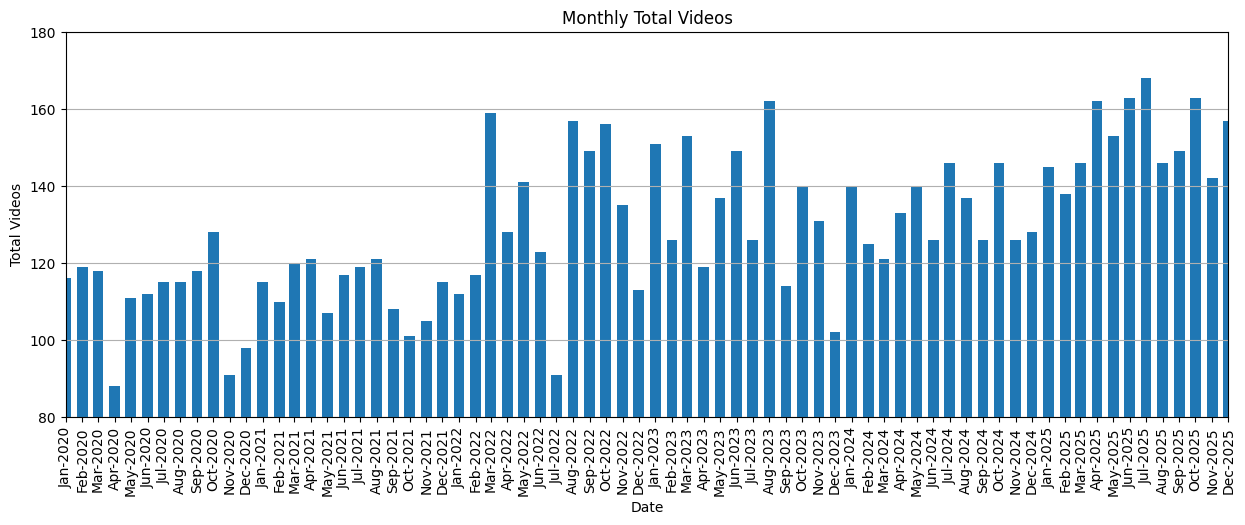

In [38]:
# bar graph: video count
plt.figure(figsize=(15, 5))
plt.bar(monthly_data.index, monthly_data["video_count"], width=20)
plt.title("Monthly Total Videos")
plt.xlabel("Date")

plt.ylabel("Total Videos")
plt.grid(axis="y", alpha=1)
plt.xticks(rotation=90)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_xlim(monthly_data.index.min(), monthly_data.index.max())
ax.set_ylim(80, 180)

plt.show()

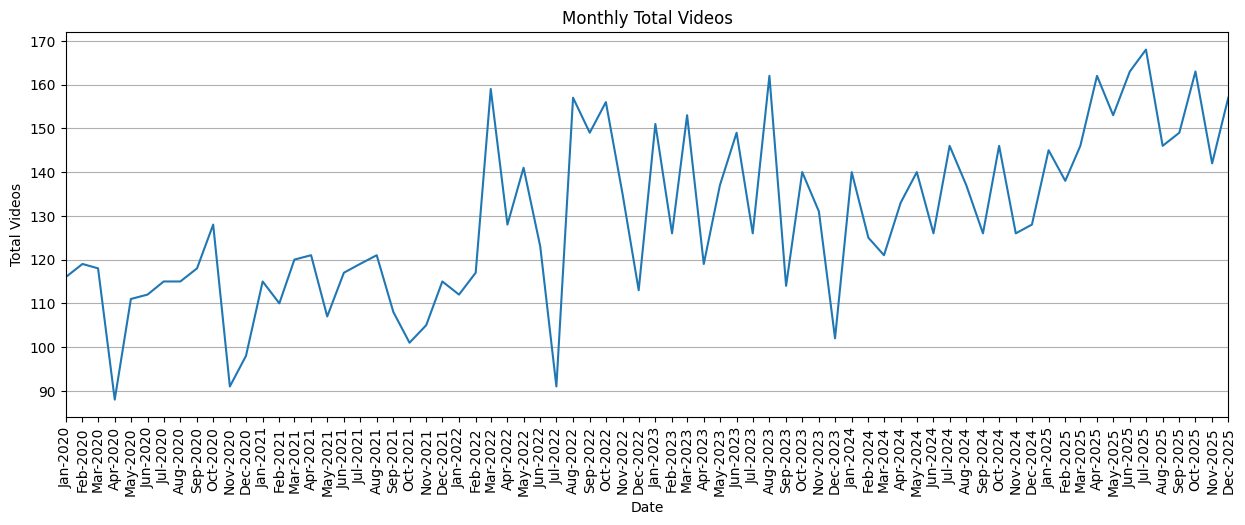

In [39]:
# line graph: video count
plt.figure(figsize=(15, 5))
plt.plot(monthly_data.index, monthly_data["video_count"])
plt.title("Monthly Total Videos")
plt.xlabel("Date")
plt.ylabel("Total Videos")
plt.grid(axis="y", alpha=1)
plt.xticks(rotation=90)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_xlim(monthly_data.index.min(), monthly_data.index.max())

plt.show()

In [40]:
# build tidy frame
monthly_tidy = monthly_data[["video_count"]].assign(
    year=monthly_data.index.year,
    month=monthly_data.index.month
)

# pivot: months as rows, years as columns
monthly_pivot = (monthly_data["video_count"]
                 .to_frame()
                 .assign(
                     year=monthly_data.index.year,
                     month=monthly_data.index.month
                     )
                 .pivot_table(
                     index="month",
                     columns="year",
                     values="video_count",
                     aggfunc="sum"
                     )
                 .sort_index()
                 )

# fix x axis
monthly_pivot.index = monthly_pivot.index.map(
    lambda m: pd.to_datetime(str(m), format="%m").strftime("%b")
)

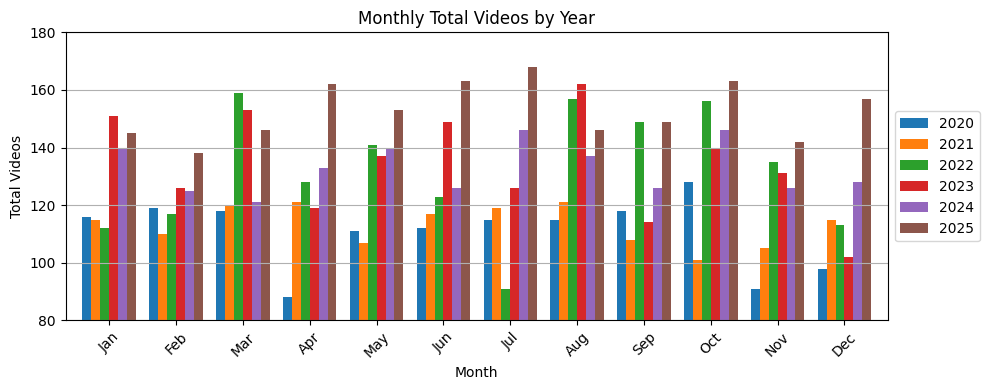

In [41]:
# grouped bar chart
ax = monthly_pivot.plot(kind="bar", figsize=(10, 4), width=0.8)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel("Month")
ax.set_ylabel("Total Videos")
ax.set_ylim(80, 180)
ax.set_title("Monthly Total Videos by Year")
ax.grid(axis="y", alpha=1)
ax.legend(title="Year")
ax.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

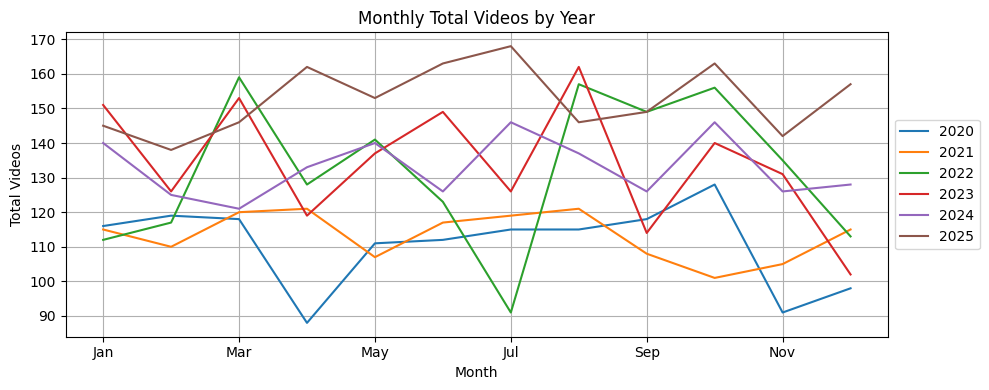

In [42]:
# line graph
ax = monthly_pivot.plot(kind="line", figsize=(10, 4))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel("Month")
ax.set_ylabel("Total Videos")
ax.set_title("Monthly Total Videos by Year")
ax.grid(True, alpha=1)
ax.legend(title="Year")
ax.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()